In [1]:
using Gen
using Flux
using JLD
using Random
using StatsBase
using LinearAlgebra
using PyPlot
using Distributions

include("LoadData.jl")
include("NUTS.jl")
include("proposals.jl")
include("utils.jl");

In [2]:
#Load Boston Housing Data

dx, dy, x_train, x_test, y_train, y_test = load_data(10);

In [3]:
#Network Hyperparameters

#Network hyperparameters
k_real = 2 #Number of hidden nodes per layer
k_vector = [0.0 for i=1:k_real]
k_vector[k_real] = 1.0

#Layer hyperparameters
l_range = 8 #Maximum number of layers in the network
l_list = [Int(i) for i in 1:l_range]
l_real = 1;

In [4]:
#Bayesian Neural Network 

function G(x, trace)
    activation = relu
    l = trace[:l]
    ks = [trace[(:k,i)] for i=1:l]
    
    for i=1:l
        in_dim, out_dim = layer_unpacker(i, l, ks)
        W = reshape(trace[(:W,i)], out_dim, in_dim)
        b = reshape(trace[(:b,i)], trace[(:k,i)])
        nn = Dense(W, b, activation)
        x = nn(x)
    end
    
    Wₒ = reshape(trace[(:W,l+1)], 1, ks[l])
    bₒ = reshape(trace[(:b,l+1)], 1)
    
    nn_out = Dense(Wₒ, bₒ)
    return nn_out(x)
end;

In [72]:
#Probabilistic Model

@gen function interpolator(x)
    
    d = length(x[:,1])
    
    #Create a blank choicemap
    obs = choicemap()::ChoiceMap
    
    #Draw number of layers
    l ~ categorical([1/length(l_list) for i=1:length(l_list)])
    l_real = l
    obs[:l] = l
    
    #Create individual weight and bias vectors
    #Loop through hidden layers
    k = [Int(0) for i=1:l+1]
    for i=1:l
        k[i] = @trace(categorical(k_vector), (:k,i))
        obs[(:k,i)] = k[i]
    end
    k[l+1] = @trace(categorical([1.0]), (:k,l+1))
    obs[(:k,l+1)] = k[l+1]
    
    #####################################
    #New hyperparameter schedule - Mar 8#
    #####################################
    
    #Standard Deviations
    τ₁ ~ gamma(100,0.01) #(100,0.01) Hidden weights and biases
    τ₂ ~ gamma(100*4,0.01) #(100*k,0.01) Output weights and biases
    #τᵧ ~ gamma(100,0.2) #(100,0.5)
    τᵧ ~ gamma(1,1)
    
    σ₁ = 1/τ₁
    σ₂ = 1/τ₂
    σᵧ = 1/τᵧ
    
    #Sample weight and bias vectors
    W = [zeros(k[i]) for i=1:l+1]
    b = [zeros(k[i]) for i=1:l+1]

    for i=1:l+1
        if i == 1
            h = Int(d * k[i])
        else
            h = Int(k[i-1] * k[i])
        end

        if i<=l
            #Hidden Weights
            u = zeros(h)
            S = Diagonal([σ₁ for i=1:length(u)])::Diagonal{<:Real}
            W[i] = @trace(mvnormal(u,S), (:W,i))
            obs[(:W,i)] = W[i]
            
            #Hidden Biases
            ub = zeros(k[i])
            Sb = Diagonal([σ₁ for i=1:length(ub)])::Diagonal{<:Real}    
            b[i] = @trace(mvnormal(ub,Sb), (:b,i))
            obs[(:b,i)] = b[i]
        else
            #Output Weights
            u = zeros(k[l])
            S = Diagonal([σ₂ for i=1:length(u)])::Diagonal{<:Real}
            W[i] = @trace(mvnormal(u,S), (:W,i))
            obs[(:W,i)] = W[i]

            #Output Bias
            ub = zeros(1)
            Sb = Diagonal([σ₂ for i=1:length(ub)])::Diagonal{<:Real}  
            b[i] = @trace(mvnormal(ub,Sb), (:b,i))
            obs[(:b,i)] = b[i]
        end
    end
    
    #Return Network Scores for X
    scores = transpose(G(x,obs))[:,1]
    
    #Regression Likelihood
    Sy = Diagonal([σᵧ for i=1:length(x[1,:])])::Diagonal{<:Real}
    y = @trace(mvnormal(vec(scores), Sy), (:y))

    return scores
    
end

obs_master = choicemap()::ChoiceMap
obs_master[:y] = y_train
obs = obs_master;
(trace,) = generate(interpolator, (x_train,), obs);

In [74]:
#Straight NUTS
Δ_max = 1000
#(trace,) = generate(interpolator, (x_train,), obs)
#println(trace[:l])
#trace = best_trace
sigma = 1/(trace[:τᵧ]) #Best so far: 3.0483
println("$sigma")

#Trace 1
param_selection = select()

for i=1:trace[:l]+1 #Number of Layers
    push!(param_selection, (:W,i))
    push!(param_selection, (:b,i))
end

m=200

traces = NUTS(trace, param_selection, 0.15, m+1, 3, true); #m+1, m=100, 0.65
#accs = []

1.0639382145787857
3
[NUTS] start sampling for 201 samples with inital ϵ=2.0
.........................................................................................................................................................................................................
[NUTS] sampling complete with final apated ϵ = 8.772582038764716


In [94]:
#Hyperparameter HMC Test

iters = 100
eps = 0.1
L = 10

hyper_selection = select()
push!(hyper_selection, :τ₁)
push!(hyper_selection, :τ₂)

obs = obs_master;
(trace,) = generate(interpolator, (x_train,), obs)
obs[:l] = trace[:l]
println(obs[:l])
for i=1:trace[:l]+1
    obs[(:W,i)] = trace[(:W,i)]
    obs[(:b,i)] = trace[(:b,i)]
end
(trace,) = generate(interpolator, (x_train,), obs)

traces = []

for i=1:iters
    (trace, acc) = hmc(trace, hyper_selection, L=L, eps=eps, check=false, observations=obs)
    push!(traces,trace)
end

3
true
true
true
true
true
true
true
false
true
true
true
true
true
true
true
true
true
true


InterruptException: InterruptException:

In [109]:
#-------------
#Run Inference
#-------------

include("NUTS.jl")
Δ_max = 1000
acc_prob = 0.25
#Random.seed!(1)

scores = []
traces = []
ks = []
across_acceptance = []
within_acceptance = []
hyper_acceptance = []
noise_acceptance = []

#HMC Hyperparameters
iters = 1
m = 1
L = 10
eps = 0.1

function propose_hyperparameters(trace)
    obs = obs_master;
    obs[:l] = trace[:l]
    for i=1:trace[:l]+1
        obs[(:W,i)] = trace[(:W,i)]
        obs[(:b,i)] = trace[(:b,i)]
    end
    
    hyper_selection = select()
    push!(hyper_selection, :τ₁)
    push!(hyper_selection, :τ₂)
    (trace, acc) = hmc(trace, hyper_selection, L=L, eps=eps, check=false, observations=obs)
    if acc 
        return (trace,1)
    else
        return (trace,0)
    end
end

function propose_noise(trace)
    
    hyper_selection = select()
    push!(hyper_selection, :τᵧ)
    (new_trace, weight, retdiff) = regenerate(trace, hyper_selection)
    
    if log(rand()) < weight
        return (new_trace, 1)
    else
        return (trace, 0)
    end
end;

function nuts_parameters(trace)
    
    l = trace[:l]
    param_selection = select()
    for i=1:l+1 #Number of Layers
        push!(param_selection, (:W,i))
        push!(param_selection, (:b,i))
    end
    
    prev_score = get_score(trace)
    
    acc = 0
    for i=1:iters
        new_trace = NUTS(trace, param_selection, acc_prob, m, m, false)[m+1]
        new_score = get_score(new_trace)
        if prev_score != new_score
            return (new_trace, 1)
        else
            return (trace, 0)
        end
    end
    
    return (trace, acc)
end

function layer_parameter(trace)
    obs = obs_master
    obs[:τ₁] = trace[:τ₁]
    obs[:τ₂] = trace[:τ₂]
    obs[:τᵧ] = trace[:τᵧ]
    
    init_trace = trace
    
    #################################################RJNUTS#################################################
    #NUTS Step 1
    trace_tilde = trace
    for i=1:iters
        #(trace_tilde,) = propose_hyperparameters(trace_tilde)
        (trace_tilde,) = nuts_parameters(trace_tilde)
    end
    
    #Reversible Jump Step
    (trace_prime, q_weight) = layer_change(trace_tilde)
    
    #NUTS Step 2
    trace_star = trace_prime
    for i=1:iters
        (trace_star,) = nuts_parameters(trace_star)
        #(trace_star,) = propose_hyperparameters(trace_star) 
    end
    #################################################RJNUTS#################################################
        
    model_score = -get_score(init_trace) + get_score(trace_star)
    across_score = model_score + q_weight
    #println(across_score)
    #println(model_score)

    if rand() < exp(across_score)
        println("********** Accepted: $(trace_star[:l]) **********")
        return (trace_star, 1)
    else
        return (init_trace, 0)
    end
end

obs_master = choicemap()::ChoiceMap
obs_master[:y] = y_train
obs = obs_master;

(trace,) = generate(interpolator, (x_train,), obs)

for i=1:100
    (trace, accepted) = layer_parameter(trace)
    push!(across_acceptance, accepted)
    #(trace, accepted)  = propose_hyperparameters(trace)
    #push!(hyper_acceptance, accepted)
    (trace, accepted)  = propose_noise(trace)
    push!(noise_acceptance, accepted)
    (trace, accepted)  = nuts_parameters(trace)
    push!(within_acceptance, accepted)
    push!(scores,get_score(trace))
    push!(traces, trace)
    println("$i : $(get_score(trace))")
    if i%10 == 0
        a_acc = 100*(sum(across_acceptance)/length(across_acceptance))
        w_acc = 100*(sum(within_acceptance)/length(within_acceptance))
        #h_acc = 100*(sum(hyper_acceptance)/length(hyper_acceptance))
        n_acc = 100*(sum(noise_acceptance)/length(noise_acceptance))
        println("Epoch $i A Acceptance Probability: $a_acc %")
        println("Epoch $i W Acceptance Probability: $w_acc %")
        #println("Epoch $i H Acceptance Probability: $h_acc %")
        println("Epoch $i N Acceptance Probability: $n_acc %")
    end
end

********** Accepted: 7 **********
1 : -531.5415389380358
********** Accepted: 8 **********
2 : -477.10221931026
********** Accepted: 7 **********
3 : -471.699516311307
********** Accepted: 8 **********
4 : -482.4969056107309
********** Accepted: 7 **********
5 : -464.85538579882666
6 : -468.30959659772634
********** Accepted: 6 **********
7 : -458.34556667928143
********** Accepted: 7 **********
8 : -464.30487515203504
********** Accepted: 6 **********
9 : -455.61658800047053
********** Accepted: 7 **********
10 : -463.72822659927965
Epoch 10 A Acceptance Probability: 90.0 %
Epoch 10 W Acceptance Probability: 90.0 %
Epoch 10 N Acceptance Probability: 30.0 %
11 : -471.195793153142
********** Accepted: 6 **********
12 : -460.320433121223
********** Accepted: 7 **********
13 : -469.93185794551516
14 : -468.68668598346744
15 : -467.5438907468166
********** Accepted: 8 **********
16 : -468.1103011379512
********** Accepted: 7 **********
17 : -462.3572962676561
18 : -462.27071074717173
*****

InterruptException: InterruptException:

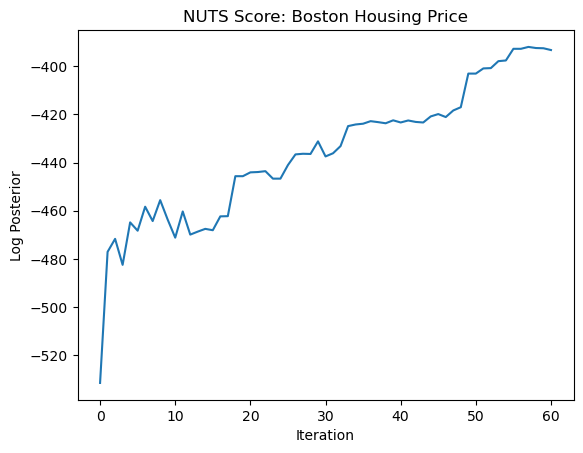

In [110]:
#-----------------------------------
#Plot Log Posterior Scores by Trace
#-----------------------------------

plot([get_score(trace) for trace in traces])
plt.title("NUTS Score: Boston Housing Price")
plt.xlabel("Iteration")
plt.ylabel("Log Posterior");

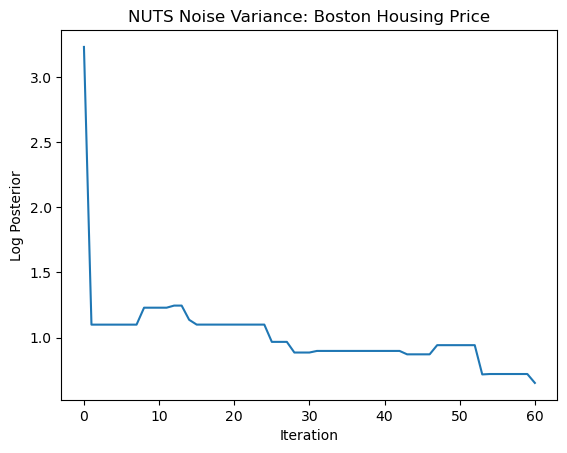

In [111]:
#----------------------------------------
#Plot Regression Noise Variance by Trace
#----------------------------------------

plot([1/trace[:τᵧ] for trace in traces])
plt.title("NUTS Noise Variance: Boston Housing Price")
plt.xlabel("Iteration")
plt.ylabel("Log Posterior");

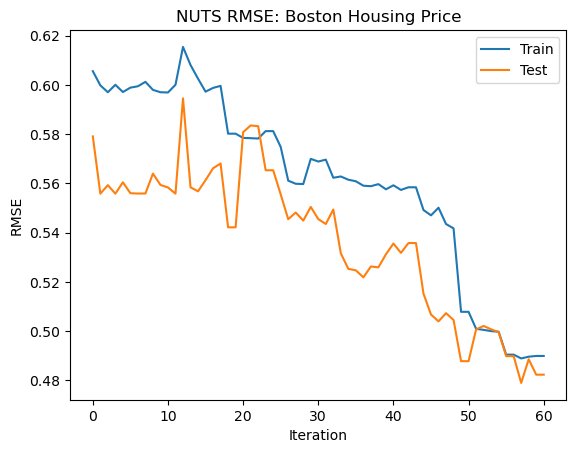

In [112]:
#-------------------------------
#Plot RMSE Train Scores by Trace
#-------------------------------

mses_train = []
for i=1:length(traces)
    trace = traces[i]
    pred_y = transpose(G(x_train,trace))[:,1]
    mse = mse_scaled(pred_y,y_train)

    push!(mses_train,mse)
end

mses_test = []
for i=1:length(traces)
    trace = traces[i]
    pred_y = transpose(G(x_test,trace))[:,1]
    mse = mse_scaled(pred_y,y_test)

    push!(mses_test,mse)
end

plot(mses_train,label="Train")
plot(mses_test, label="Test")
plt.title("NUTS RMSE: Boston Housing Price")
plt.xlabel("Iteration")
plt.ylabel("RMSE");
plt.legend()

best_trace = traces[1]
for i=1:length(traces)
    if get_score(traces[i]) > get_score(best_trace)
        best_trace = traces[i]
    end
end

In [113]:
#----------------
#Marginalize RMSE
#----------------
j = 1
y_marginal = zeros(length(y_train))

for i=j:length(traces)
    trace = traces[i]
    pred_y = transpose(G(x_train,trace))[:,1]
    y_marginal += (pred_y/(length(traces)-j))
end

#display(y_marginal[1:5])
#display(y[1:5])

mse = mse_scaled(y_marginal, y_train)
println("Training Set Marginal RMSE: $mse")

j = 1
y_marginal = zeros(length(y_test))

for i=j:length(traces)
    trace = traces[i]
    pred_y = transpose(G(x_test,trace))[:,1]
    y_marginal += (pred_y/(length(traces)-j))
end

#display(y_marginal[1:5])
#display(y[1:5])

mse = mse_scaled(y_marginal, y_test)
println("Test Set Marginal RMSE: $mse")

Training Set Marginal RMSE: 0.5495086243317285
Test Set Marginal RMSE: 0.5241248093600622
